Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance Segmentation of Powder Particles and Satellites

This example will take you through the process of training a model to segment powder particles and visualizing the model predictions.

In [2]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

root = '../../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/initial_paper_complete_set/'
ocean_syn = root + '../../../../ocean/projects/dmr200021p/sprice/synthetic_training/'
sys.path.append(root)

from ampis import data_utils, visualize, export_anno

%matplotlib inline

# Labeling Data

The [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/) was used to generate particle labels. The a

# Loading Data
The process for training models for powder particles and satellites is identical. Enter the corresponding value depending on which model you want to train. <br />
The paths to individual images, and all annotation data are stored in the JSON files generated by the VGG image annotator.



In [3]:
EXPERIMENT_NAME = 'satellite' # can be 'particle' or 'satellite'
json_path_train = Path(ocean_syn,'trainings','synthetic_training_satellite_AMPIS1.0.json')  # path to training data
json_path_val = Path(ocean_syn,'trainings', 'synthetic_validation_satellite_AMPIS1.0.json')  # path to training data
assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'


## Registration
Detectron2 requires that datasets be registered for later use.
Registration stores the name of the dataset and a function that can be used to retrieve the image paths and labels in a format that the model can use.

In [3]:
DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times

# store names of datasets that will be registered for easier access later
dataset_train = f'{EXPERIMENT_NAME}_Train'
dataset_valid = f'{EXPERIMENT_NAME}_Val'

# register the training dataset
DatasetCatalog.register(dataset_train, lambda f = json_path_train: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                     im_root=f,  # path to the training data json file
                                                                                                     dataset_class='Train'))  # indicates this is training data
# register the validation dataset
DatasetCatalog.register(dataset_valid, lambda f = json_path_val: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                im_root=f,  # path to validation data json file
                                                                                                dataset_class='Validation'))  # indicates this is validation data
                              
print(f'Registered Datasets: {DatasetCatalog.list()}')

## There is also a metadata catalog, which stores the class names.
for d in [dataset_train, dataset_valid]:
    MetadataCatalog.get(d).set(**{'thing_classes': [EXPERIMENT_NAME]})

Registered Datasets: ['satellite_Train', 'satellite_Val']


## Verify images and annotations are loaded correctly
Also, this is a great time to admire my hand-drawn labels, which took sooooo long to do!
### Training Data

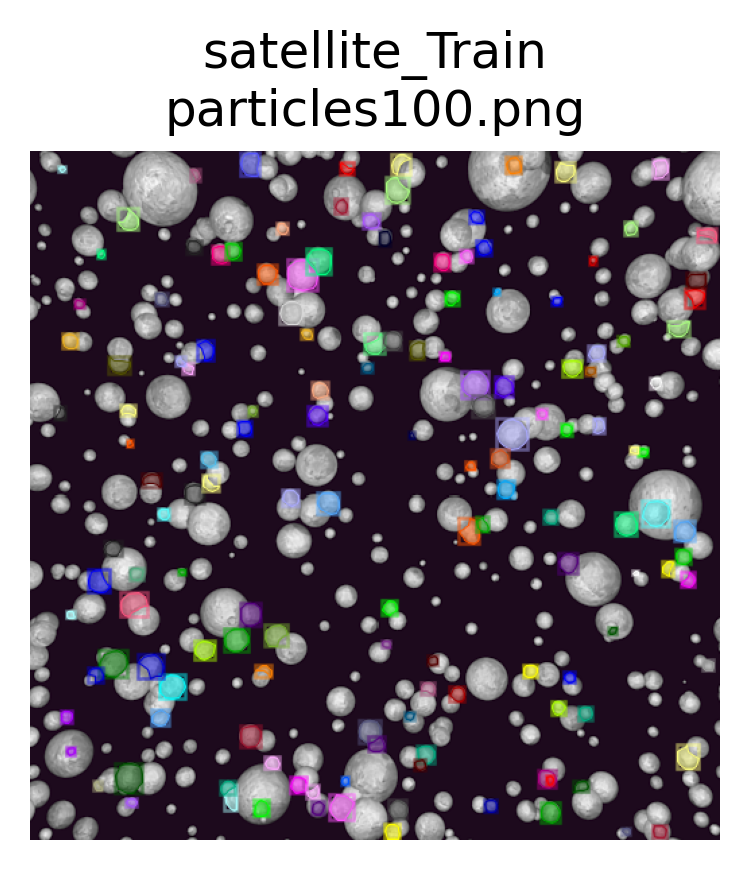

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png
	num_instances: 148


ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles101.png
	num_instances: 139


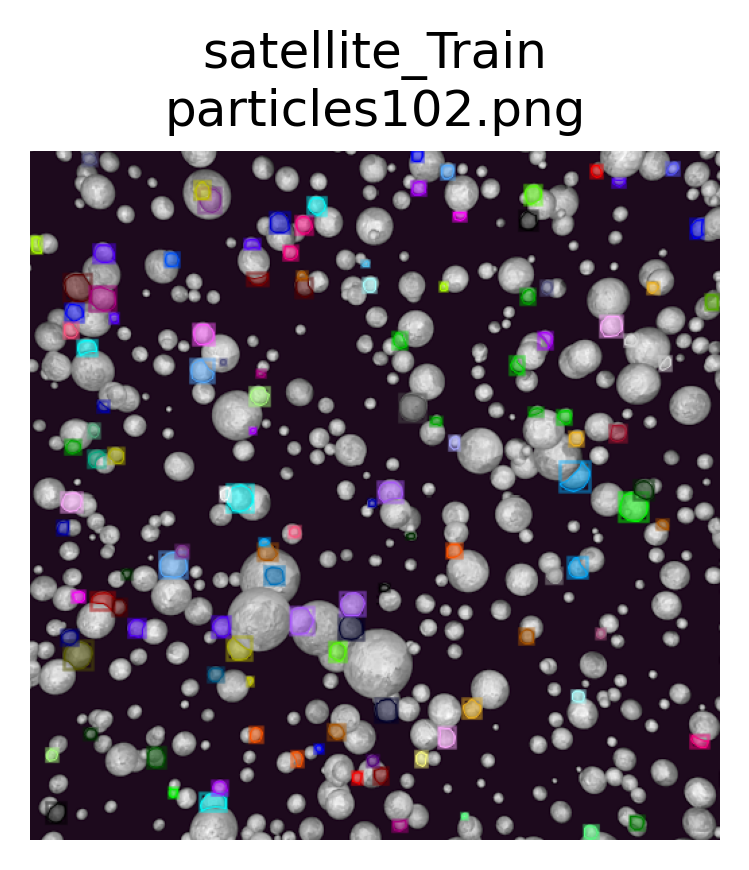

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles102.png
	num_instances: 123


In [4]:
#for i in np.random.choice(DatasetCatalog.get(dataset_train), 3, replace=False):
    #visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)
for i in DatasetCatalog.get(dataset_train):
    visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)

### Validation Data

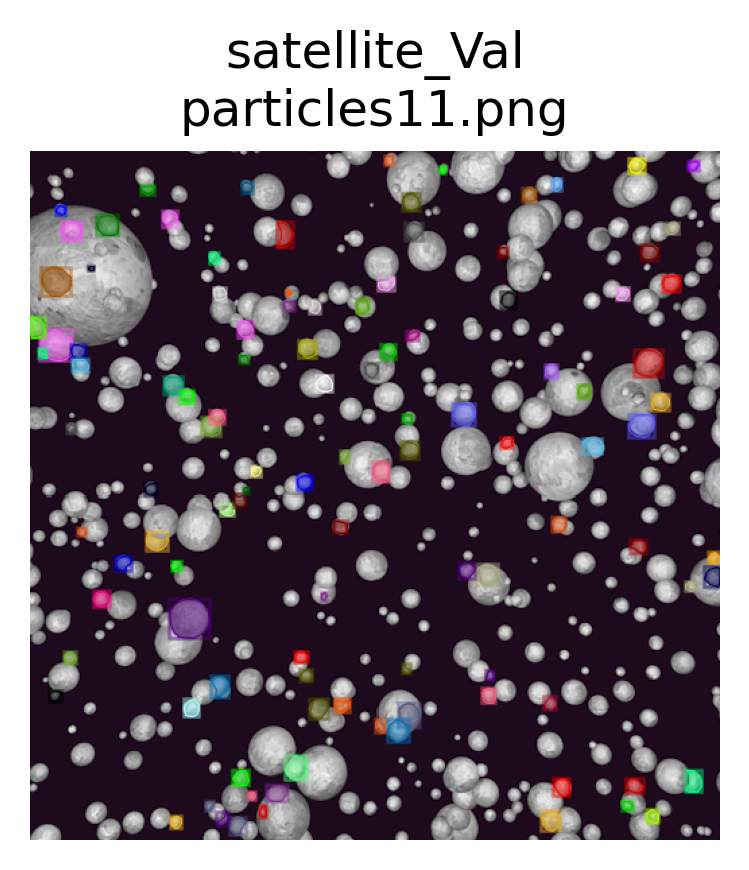

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png
	num_instances: 110


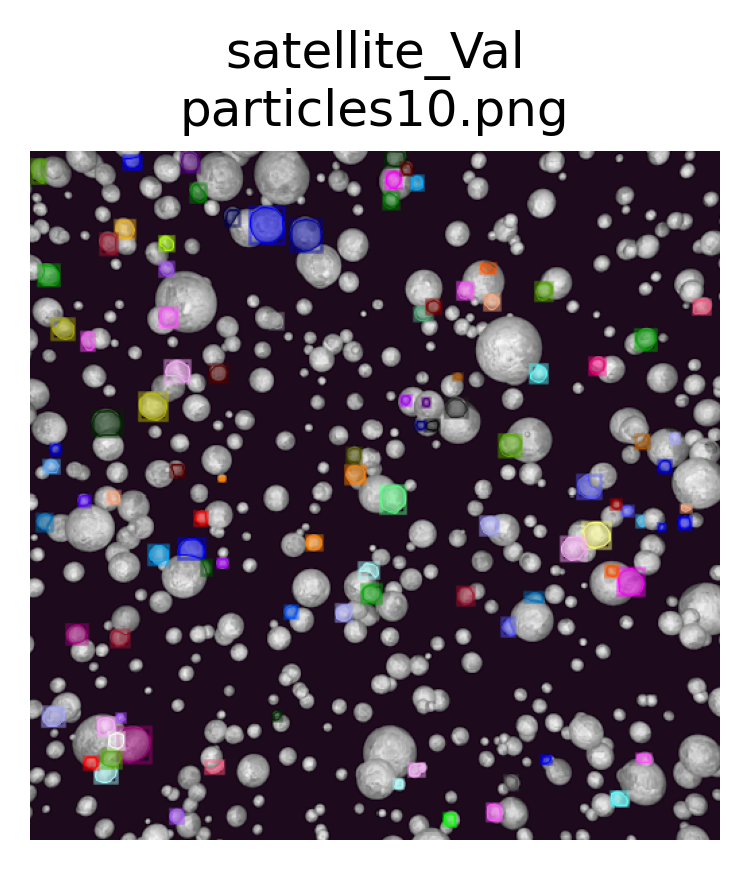

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png
	num_instances: 101


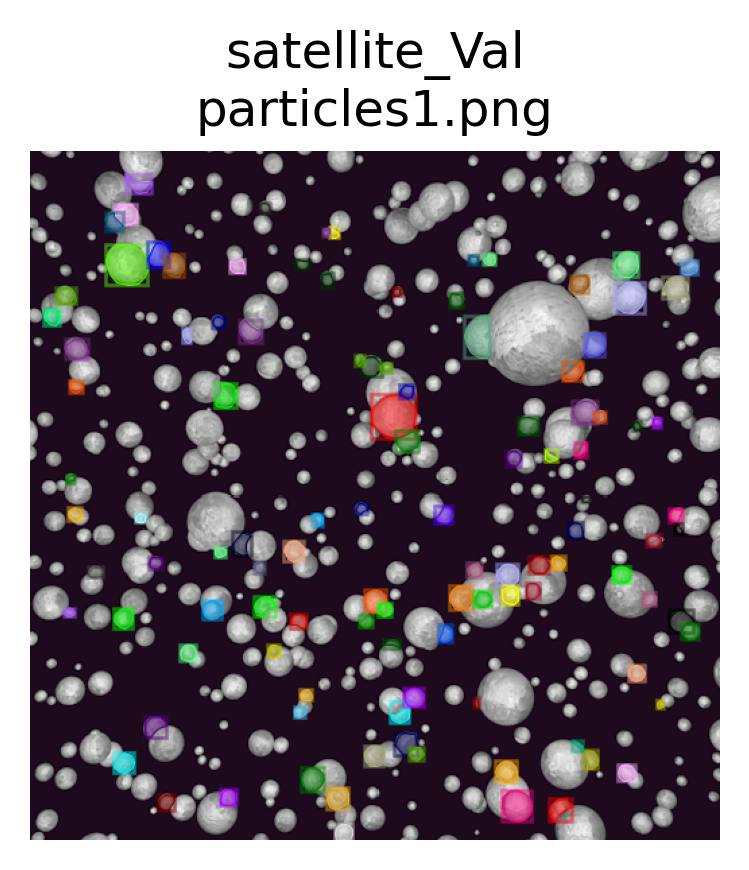

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png
	num_instances: 110


In [6]:
for i in DatasetCatalog.get(dataset_valid):
    visualize.display_ddicts(i, None, dataset_valid, suppress_labels=True)

## Model Configuration
This is where we specify the directory where the outputs are saved, various hyperparameters for the model, and more.

In [4]:
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 15000  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

# model weights will be downloaded if they are not present
weights_path = Path('..','..','models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path(ocean_syn,'Models', 'Synthetic_training_a1.4'))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)

Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl


# Model Training
Once we have everything set up, training is very easy!

Note- this block will generate a huge wall of text.

In [5]:
trainer = DefaultTrainer(cfg)  # create trainer object from cfg
trainer.resume_or_load(resume=False)  # start training from iteration 0
trainer.train()  # train the model!

[07/27 20:42:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/27 20:42:40 d2.data.build]: Removed 0 images with no usable annotations. 5 images left.
[07/27 20:42:40 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| satellite  | 716          |
|            |              |
[07/27 20:42:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/27 20:42:40 d2.data.build]: Using training sampler TrainingSampler
[07/27 20:42:40 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[07/27 20:42:40 d2.data.common]: Serialized dataset takes 0.20 MiB
WARNING [07/27 20:42:40 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


/jet/home/sprice/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[07/27 20:42:41 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[07/27 20:42:41 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  

[07/27 20:43:12 d2.utils.events]:  eta: 0:32:32  iter: 219  total_loss: 1.618  loss_cls: 0.258  loss_box_reg: 0.3748  loss_mask: 0.382  loss_rpn_cls: 0.2408  loss_rpn_loc: 0.3334  time: 0.1331  data_time: 0.0148  lr: 0.0043956  max_mem: 1622M
[07/27 20:43:15 d2.utils.events]:  eta: 0:32:29  iter: 239  total_loss: 1.54  loss_cls: 0.2506  loss_box_reg: 0.4011  loss_mask: 0.3404  loss_rpn_cls: 0.2223  loss_rpn_loc: 0.3066  time: 0.1332  data_time: 0.0146  lr: 0.0047952  max_mem: 1622M
[07/27 20:43:17 d2.utils.events]:  eta: 0:32:30  iter: 259  total_loss: 1.537  loss_cls: 0.2378  loss_box_reg: 0.396  loss_mask: 0.342  loss_rpn_cls: 0.2432  loss_rpn_loc: 0.3237  time: 0.1333  data_time: 0.0146  lr: 0.0051948  max_mem: 1622M
[07/27 20:43:20 d2.utils.events]:  eta: 0:32:26  iter: 279  total_loss: 1.523  loss_cls: 0.2359  loss_box_reg: 0.3662  loss_mask: 0.3352  loss_rpn_cls: 0.2693  loss_rpn_loc: 0.31  time: 0.1333  data_time: 0.0147  lr: 0.0055944  max_mem: 1622M
[07/27 20:43:23 d2.utils.ev

[07/27 20:44:41 d2.utils.events]:  eta: 0:31:08  iter: 879  total_loss: 1.121  loss_cls: 0.1451  loss_box_reg: 0.3061  loss_mask: 0.2241  loss_rpn_cls: 0.1266  loss_rpn_loc: 0.2978  time: 0.1338  data_time: 0.0139  lr: 0.017582  max_mem: 1622M
[07/27 20:44:44 d2.utils.events]:  eta: 0:31:05  iter: 899  total_loss: 1.135  loss_cls: 0.1744  loss_box_reg: 0.2969  loss_mask: 0.2124  loss_rpn_cls: 0.1418  loss_rpn_loc: 0.2925  time: 0.1338  data_time: 0.0145  lr: 0.017982  max_mem: 1622M
[07/27 20:44:47 d2.utils.events]:  eta: 0:31:03  iter: 919  total_loss: 1.115  loss_cls: 0.1688  loss_box_reg: 0.2832  loss_mask: 0.2114  loss_rpn_cls: 0.1443  loss_rpn_loc: 0.2949  time: 0.1338  data_time: 0.0144  lr: 0.018382  max_mem: 1622M
[07/27 20:44:49 d2.utils.events]:  eta: 0:31:00  iter: 939  total_loss: 1.085  loss_cls: 0.1426  loss_box_reg: 0.2823  loss_mask: 0.1963  loss_rpn_cls: 0.1634  loss_rpn_loc: 0.3154  time: 0.1337  data_time: 0.0146  lr: 0.018781  max_mem: 1622M
[07/27 20:44:52 d2.utils

[07/27 20:46:14 d2.utils.events]:  eta: 0:29:39  iter: 1539  total_loss: 0.9258  loss_cls: 0.1191  loss_box_reg: 0.2512  loss_mask: 0.1749  loss_rpn_cls: 0.1019  loss_rpn_loc: 0.2625  time: 0.1337  data_time: 0.0151  lr: 0.02  max_mem: 1622M
[07/27 20:46:17 d2.utils.events]:  eta: 0:29:37  iter: 1559  total_loss: 0.9257  loss_cls: 0.118  loss_box_reg: 0.2392  loss_mask: 0.1808  loss_rpn_cls: 0.1041  loss_rpn_loc: 0.2728  time: 0.1337  data_time: 0.0147  lr: 0.02  max_mem: 1622M
[07/27 20:46:20 d2.utils.events]:  eta: 0:29:35  iter: 1579  total_loss: 0.9041  loss_cls: 0.113  loss_box_reg: 0.2501  loss_mask: 0.1748  loss_rpn_cls: 0.1097  loss_rpn_loc: 0.2423  time: 0.1337  data_time: 0.0147  lr: 0.02  max_mem: 1622M
[07/27 20:46:22 d2.utils.events]:  eta: 0:29:31  iter: 1599  total_loss: 0.8852  loss_cls: 0.1078  loss_box_reg: 0.2339  loss_mask: 0.167  loss_rpn_cls: 0.1121  loss_rpn_loc: 0.2481  time: 0.1337  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 20:46:25 d2.utils.events]:  

[07/27 20:47:47 d2.utils.events]:  eta: 0:28:18  iter: 2199  total_loss: 0.7569  loss_cls: 0.09548  loss_box_reg: 0.2109  loss_mask: 0.1472  loss_rpn_cls: 0.07901  loss_rpn_loc: 0.2288  time: 0.1337  data_time: 0.0148  lr: 0.02  max_mem: 1622M
[07/27 20:47:50 d2.utils.events]:  eta: 0:28:16  iter: 2219  total_loss: 0.7543  loss_cls: 0.09618  loss_box_reg: 0.2017  loss_mask: 0.145  loss_rpn_cls: 0.06907  loss_rpn_loc: 0.232  time: 0.1338  data_time: 0.0155  lr: 0.02  max_mem: 1622M
[07/27 20:47:53 d2.utils.events]:  eta: 0:28:13  iter: 2239  total_loss: 0.792  loss_cls: 0.0956  loss_box_reg: 0.2079  loss_mask: 0.1366  loss_rpn_cls: 0.08841  loss_rpn_loc: 0.253  time: 0.1338  data_time: 0.0146  lr: 0.02  max_mem: 1622M
[07/27 20:47:55 d2.utils.events]:  eta: 0:28:10  iter: 2259  total_loss: 0.7609  loss_cls: 0.1012  loss_box_reg: 0.2015  loss_mask: 0.1486  loss_rpn_cls: 0.08743  loss_rpn_loc: 0.2315  time: 0.1338  data_time: 0.0146  lr: 0.02  max_mem: 1622M
[07/27 20:47:58 d2.utils.event

[07/27 20:49:16 d2.utils.events]:  eta: 0:26:51  iter: 2859  total_loss: 0.723  loss_cls: 0.0831  loss_box_reg: 0.189  loss_mask: 0.1401  loss_rpn_cls: 0.07127  loss_rpn_loc: 0.2192  time: 0.1337  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 20:49:19 d2.utils.events]:  eta: 0:26:48  iter: 2879  total_loss: 0.6889  loss_cls: 0.08206  loss_box_reg: 0.1903  loss_mask: 0.1287  loss_rpn_cls: 0.06288  loss_rpn_loc: 0.2046  time: 0.1337  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 20:49:21 d2.utils.events]:  eta: 0:26:45  iter: 2899  total_loss: 0.7069  loss_cls: 0.08743  loss_box_reg: 0.2046  loss_mask: 0.1272  loss_rpn_cls: 0.07418  loss_rpn_loc: 0.2155  time: 0.1337  data_time: 0.0146  lr: 0.02  max_mem: 1622M
[07/27 20:49:24 d2.utils.events]:  eta: 0:26:42  iter: 2919  total_loss: 0.66  loss_cls: 0.07965  loss_box_reg: 0.196  loss_mask: 0.1236  loss_rpn_cls: 0.04816  loss_rpn_loc: 0.2055  time: 0.1337  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 20:49:27 d2.utils.event

[07/27 20:50:47 d2.utils.events]:  eta: 0:25:00  iter: 3519  total_loss: 0.6045  loss_cls: 0.06976  loss_box_reg: 0.1681  loss_mask: 0.1081  loss_rpn_cls: 0.04599  loss_rpn_loc: 0.1973  time: 0.1332  data_time: 0.0144  lr: 0.02  max_mem: 1622M
[07/27 20:50:49 d2.utils.events]:  eta: 0:24:57  iter: 3539  total_loss: 0.6024  loss_cls: 0.07533  loss_box_reg: 0.1787  loss_mask: 0.1083  loss_rpn_cls: 0.05369  loss_rpn_loc: 0.194  time: 0.1332  data_time: 0.0138  lr: 0.02  max_mem: 1622M
[07/27 20:50:52 d2.utils.events]:  eta: 0:24:54  iter: 3559  total_loss: 0.6068  loss_cls: 0.07166  loss_box_reg: 0.1765  loss_mask: 0.1116  loss_rpn_cls: 0.06337  loss_rpn_loc: 0.1908  time: 0.1332  data_time: 0.0139  lr: 0.02  max_mem: 1622M
[07/27 20:50:55 d2.utils.events]:  eta: 0:24:50  iter: 3579  total_loss: 0.6029  loss_cls: 0.067  loss_box_reg: 0.1738  loss_mask: 0.1096  loss_rpn_cls: 0.04971  loss_rpn_loc: 0.1919  time: 0.1332  data_time: 0.0146  lr: 0.02  max_mem: 1622M
[07/27 20:50:57 d2.utils.ev

[07/27 20:52:18 d2.utils.events]:  eta: 0:23:20  iter: 4179  total_loss: 0.5531  loss_cls: 0.06043  loss_box_reg: 0.1516  loss_mask: 0.1026  loss_rpn_cls: 0.04572  loss_rpn_loc: 0.1803  time: 0.1328  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 20:52:21 d2.utils.events]:  eta: 0:23:17  iter: 4199  total_loss: 0.5625  loss_cls: 0.06754  loss_box_reg: 0.1587  loss_mask: 0.1039  loss_rpn_cls: 0.04964  loss_rpn_loc: 0.1883  time: 0.1328  data_time: 0.0144  lr: 0.02  max_mem: 1622M
[07/27 20:52:23 d2.utils.events]:  eta: 0:23:16  iter: 4219  total_loss: 0.5615  loss_cls: 0.07237  loss_box_reg: 0.1587  loss_mask: 0.101  loss_rpn_cls: 0.04355  loss_rpn_loc: 0.1846  time: 0.1328  data_time: 0.0142  lr: 0.02  max_mem: 1622M
[07/27 20:52:26 d2.utils.events]:  eta: 0:23:15  iter: 4239  total_loss: 0.5435  loss_cls: 0.06464  loss_box_reg: 0.1598  loss_mask: 0.09937  loss_rpn_cls: 0.04509  loss_rpn_loc: 0.1875  time: 0.1328  data_time: 0.0152  lr: 0.02  max_mem: 1622M
[07/27 20:52:29 d2.utils

[07/27 20:53:46 d2.utils.events]:  eta: 0:22:04  iter: 4839  total_loss: 0.5511  loss_cls: 0.05934  loss_box_reg: 0.1485  loss_mask: 0.09387  loss_rpn_cls: 0.0499  loss_rpn_loc: 0.1789  time: 0.1327  data_time: 0.0140  lr: 0.02  max_mem: 1622M
[07/27 20:53:49 d2.utils.events]:  eta: 0:22:03  iter: 4859  total_loss: 0.5681  loss_cls: 0.06856  loss_box_reg: 0.1597  loss_mask: 0.09729  loss_rpn_cls: 0.04697  loss_rpn_loc: 0.1764  time: 0.1327  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 20:53:52 d2.utils.events]:  eta: 0:22:00  iter: 4879  total_loss: 0.5554  loss_cls: 0.06666  loss_box_reg: 0.1559  loss_mask: 0.09571  loss_rpn_cls: 0.0473  loss_rpn_loc: 0.1878  time: 0.1327  data_time: 0.0144  lr: 0.02  max_mem: 1622M
[07/27 20:53:54 d2.utils.events]:  eta: 0:21:58  iter: 4899  total_loss: 0.5487  loss_cls: 0.06178  loss_box_reg: 0.1589  loss_mask: 0.09778  loss_rpn_cls: 0.04336  loss_rpn_loc: 0.1766  time: 0.1327  data_time: 0.0139  lr: 0.02  max_mem: 1622M
[07/27 20:53:57 d2.uti

[07/27 20:55:18 d2.utils.events]:  eta: 0:20:44  iter: 5499  total_loss: 0.4862  loss_cls: 0.05729  loss_box_reg: 0.1411  loss_mask: 0.09377  loss_rpn_cls: 0.03693  loss_rpn_loc: 0.1653  time: 0.1327  data_time: 0.0149  lr: 0.02  max_mem: 1622M
[07/27 20:55:21 d2.utils.events]:  eta: 0:20:41  iter: 5519  total_loss: 0.5287  loss_cls: 0.05506  loss_box_reg: 0.1398  loss_mask: 0.08777  loss_rpn_cls: 0.054  loss_rpn_loc: 0.1811  time: 0.1327  data_time: 0.0147  lr: 0.02  max_mem: 1622M
[07/27 20:55:23 d2.utils.events]:  eta: 0:20:39  iter: 5539  total_loss: 0.518  loss_cls: 0.05339  loss_box_reg: 0.1488  loss_mask: 0.08986  loss_rpn_cls: 0.03776  loss_rpn_loc: 0.1771  time: 0.1327  data_time: 0.0144  lr: 0.02  max_mem: 1622M
[07/27 20:55:26 d2.utils.events]:  eta: 0:20:37  iter: 5559  total_loss: 0.5406  loss_cls: 0.06397  loss_box_reg: 0.1455  loss_mask: 0.09172  loss_rpn_cls: 0.05573  loss_rpn_loc: 0.1849  time: 0.1327  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 20:55:29 d2.util

[07/27 20:56:51 d2.utils.events]:  eta: 0:19:27  iter: 6159  total_loss: 0.4825  loss_cls: 0.04927  loss_box_reg: 0.1441  loss_mask: 0.08594  loss_rpn_cls: 0.03455  loss_rpn_loc: 0.1607  time: 0.1328  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 20:56:54 d2.utils.events]:  eta: 0:19:25  iter: 6179  total_loss: 0.4782  loss_cls: 0.04929  loss_box_reg: 0.1297  loss_mask: 0.08495  loss_rpn_cls: 0.04035  loss_rpn_loc: 0.1606  time: 0.1328  data_time: 0.0137  lr: 0.02  max_mem: 1622M
[07/27 20:56:57 d2.utils.events]:  eta: 0:19:22  iter: 6199  total_loss: 0.5225  loss_cls: 0.05282  loss_box_reg: 0.1554  loss_mask: 0.09027  loss_rpn_cls: 0.03782  loss_rpn_loc: 0.179  time: 0.1328  data_time: 0.0148  lr: 0.02  max_mem: 1622M
[07/27 20:56:59 d2.utils.events]:  eta: 0:19:19  iter: 6219  total_loss: 0.5178  loss_cls: 0.0532  loss_box_reg: 0.1442  loss_mask: 0.0889  loss_rpn_cls: 0.04747  loss_rpn_loc: 0.1865  time: 0.1328  data_time: 0.0140  lr: 0.02  max_mem: 1622M
[07/27 20:57:02 d2.util

[07/27 20:58:21 d2.utils.events]:  eta: 0:18:04  iter: 6819  total_loss: 0.4299  loss_cls: 0.04829  loss_box_reg: 0.1251  loss_mask: 0.08036  loss_rpn_cls: 0.02814  loss_rpn_loc: 0.1502  time: 0.1329  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 20:58:24 d2.utils.events]:  eta: 0:18:01  iter: 6839  total_loss: 0.4353  loss_cls: 0.04559  loss_box_reg: 0.1284  loss_mask: 0.08072  loss_rpn_cls: 0.03077  loss_rpn_loc: 0.1437  time: 0.1329  data_time: 0.0149  lr: 0.02  max_mem: 1622M
[07/27 20:58:26 d2.utils.events]:  eta: 0:17:59  iter: 6859  total_loss: 0.4452  loss_cls: 0.04763  loss_box_reg: 0.1461  loss_mask: 0.0792  loss_rpn_cls: 0.02581  loss_rpn_loc: 0.1485  time: 0.1329  data_time: 0.0147  lr: 0.02  max_mem: 1622M
[07/27 20:58:29 d2.utils.events]:  eta: 0:17:56  iter: 6879  total_loss: 0.4668  loss_cls: 0.04593  loss_box_reg: 0.1408  loss_mask: 0.0862  loss_rpn_cls: 0.0399  loss_rpn_loc: 0.1553  time: 0.1329  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 20:58:32 d2.util

[07/27 20:59:55 d2.utils.events]:  eta: 0:16:41  iter: 7479  total_loss: 0.4451  loss_cls: 0.04469  loss_box_reg: 0.1306  loss_mask: 0.08557  loss_rpn_cls: 0.01923  loss_rpn_loc: 0.1573  time: 0.1330  data_time: 0.0147  lr: 0.02  max_mem: 1622M
[07/27 20:59:57 d2.utils.events]:  eta: 0:16:38  iter: 7499  total_loss: 0.4743  loss_cls: 0.04738  loss_box_reg: 0.1446  loss_mask: 0.08458  loss_rpn_cls: 0.03305  loss_rpn_loc: 0.1629  time: 0.1330  data_time: 0.0150  lr: 0.02  max_mem: 1622M
[07/27 21:00:00 d2.utils.events]:  eta: 0:16:36  iter: 7519  total_loss: 0.4399  loss_cls: 0.04215  loss_box_reg: 0.132  loss_mask: 0.07973  loss_rpn_cls: 0.02746  loss_rpn_loc: 0.1477  time: 0.1330  data_time: 0.0148  lr: 0.02  max_mem: 1622M
[07/27 21:00:03 d2.utils.events]:  eta: 0:16:33  iter: 7539  total_loss: 0.4485  loss_cls: 0.05361  loss_box_reg: 0.1262  loss_mask: 0.07821  loss_rpn_cls: 0.0328  loss_rpn_loc: 0.1517  time: 0.1330  data_time: 0.0146  lr: 0.02  max_mem: 1622M
[07/27 21:00:06 d2.uti

[07/27 21:01:29 d2.utils.events]:  eta: 0:15:15  iter: 8139  total_loss: 0.4396  loss_cls: 0.04618  loss_box_reg: 0.1338  loss_mask: 0.07615  loss_rpn_cls: 0.0258  loss_rpn_loc: 0.1479  time: 0.1331  data_time: 0.0147  lr: 0.02  max_mem: 1622M
[07/27 21:01:31 d2.utils.events]:  eta: 0:15:13  iter: 8159  total_loss: 0.4439  loss_cls: 0.0453  loss_box_reg: 0.1215  loss_mask: 0.07949  loss_rpn_cls: 0.03547  loss_rpn_loc: 0.152  time: 0.1331  data_time: 0.0136  lr: 0.02  max_mem: 1622M
[07/27 21:01:34 d2.utils.events]:  eta: 0:15:10  iter: 8179  total_loss: 0.4224  loss_cls: 0.04125  loss_box_reg: 0.1134  loss_mask: 0.0752  loss_rpn_cls: 0.0248  loss_rpn_loc: 0.1557  time: 0.1331  data_time: 0.0147  lr: 0.02  max_mem: 1622M
[07/27 21:01:37 d2.utils.events]:  eta: 0:15:07  iter: 8199  total_loss: 0.4199  loss_cls: 0.04112  loss_box_reg: 0.1212  loss_mask: 0.07466  loss_rpn_cls: 0.03103  loss_rpn_loc: 0.1507  time: 0.1331  data_time: 0.0150  lr: 0.02  max_mem: 1622M
[07/27 21:01:40 d2.utils.

[07/27 21:02:59 d2.utils.events]:  eta: 0:13:49  iter: 8799  total_loss: 0.4112  loss_cls: 0.03842  loss_box_reg: 0.1155  loss_mask: 0.07196  loss_rpn_cls: 0.02689  loss_rpn_loc: 0.1435  time: 0.1333  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 21:03:02 d2.utils.events]:  eta: 0:13:46  iter: 8819  total_loss: 0.4103  loss_cls: 0.0429  loss_box_reg: 0.1212  loss_mask: 0.07608  loss_rpn_cls: 0.02851  loss_rpn_loc: 0.1437  time: 0.1333  data_time: 0.0139  lr: 0.02  max_mem: 1622M
[07/27 21:03:04 d2.utils.events]:  eta: 0:13:43  iter: 8839  total_loss: 0.4152  loss_cls: 0.03972  loss_box_reg: 0.125  loss_mask: 0.07838  loss_rpn_cls: 0.02444  loss_rpn_loc: 0.1507  time: 0.1333  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 21:03:07 d2.utils.events]:  eta: 0:13:40  iter: 8859  total_loss: 0.4039  loss_cls: 0.04331  loss_box_reg: 0.1132  loss_mask: 0.07447  loss_rpn_cls: 0.02095  loss_rpn_loc: 0.1449  time: 0.1333  data_time: 0.0144  lr: 0.02  max_mem: 1622M
[07/27 21:03:10 d2.uti

[07/27 21:04:31 d2.utils.events]:  eta: 0:12:10  iter: 9459  total_loss: 0.4092  loss_cls: 0.03835  loss_box_reg: 0.119  loss_mask: 0.07532  loss_rpn_cls: 0.0312  loss_rpn_loc: 0.1384  time: 0.1332  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 21:04:34 d2.utils.events]:  eta: 0:12:07  iter: 9479  total_loss: 0.3965  loss_cls: 0.04448  loss_box_reg: 0.1168  loss_mask: 0.07227  loss_rpn_cls: 0.02756  loss_rpn_loc: 0.14  time: 0.1332  data_time: 0.0140  lr: 0.02  max_mem: 1622M
[07/27 21:04:36 d2.utils.events]:  eta: 0:12:05  iter: 9499  total_loss: 0.4019  loss_cls: 0.03774  loss_box_reg: 0.118  loss_mask: 0.07324  loss_rpn_cls: 0.02745  loss_rpn_loc: 0.1472  time: 0.1332  data_time: 0.0132  lr: 0.02  max_mem: 1622M
[07/27 21:04:39 d2.utils.events]:  eta: 0:12:01  iter: 9519  total_loss: 0.3901  loss_cls: 0.03988  loss_box_reg: 0.1152  loss_mask: 0.07217  loss_rpn_cls: 0.02648  loss_rpn_loc: 0.1389  time: 0.1332  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 21:04:42 d2.utils.

[07/27 21:06:02 d2.utils.events]:  eta: 0:10:38  iter: 10119  total_loss: 0.3773  loss_cls: 0.03759  loss_box_reg: 0.1029  loss_mask: 0.06746  loss_rpn_cls: 0.04144  loss_rpn_loc: 0.133  time: 0.1331  data_time: 0.0136  lr: 0.02  max_mem: 1622M
[07/27 21:06:04 d2.utils.events]:  eta: 0:10:35  iter: 10139  total_loss: 0.3764  loss_cls: 0.03964  loss_box_reg: 0.1021  loss_mask: 0.06665  loss_rpn_cls: 0.0318  loss_rpn_loc: 0.141  time: 0.1331  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 21:06:07 d2.utils.events]:  eta: 0:10:33  iter: 10159  total_loss: 0.3985  loss_cls: 0.03885  loss_box_reg: 0.1146  loss_mask: 0.07505  loss_rpn_cls: 0.03166  loss_rpn_loc: 0.138  time: 0.1331  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 21:06:10 d2.utils.events]:  eta: 0:10:30  iter: 10179  total_loss: 0.4015  loss_cls: 0.04012  loss_box_reg: 0.1126  loss_mask: 0.07424  loss_rpn_cls: 0.03069  loss_rpn_loc: 0.1485  time: 0.1331  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 21:06:12 d2.u

[07/27 21:07:29 d2.utils.events]:  eta: 0:09:13  iter: 10779  total_loss: 0.3683  loss_cls: 0.042  loss_box_reg: 0.1055  loss_mask: 0.06669  loss_rpn_cls: 0.02414  loss_rpn_loc: 0.1261  time: 0.1331  data_time: 0.0140  lr: 0.02  max_mem: 1622M
[07/27 21:07:32 d2.utils.events]:  eta: 0:09:10  iter: 10799  total_loss: 0.3531  loss_cls: 0.02862  loss_box_reg: 0.1082  loss_mask: 0.06534  loss_rpn_cls: 0.02311  loss_rpn_loc: 0.129  time: 0.1331  data_time: 0.0144  lr: 0.02  max_mem: 1622M
[07/27 21:07:35 d2.utils.events]:  eta: 0:09:08  iter: 10819  total_loss: 0.344  loss_cls: 0.02811  loss_box_reg: 0.09892  loss_mask: 0.0651  loss_rpn_cls: 0.02304  loss_rpn_loc: 0.1327  time: 0.1331  data_time: 0.0146  lr: 0.02  max_mem: 1622M
[07/27 21:07:37 d2.utils.events]:  eta: 0:09:06  iter: 10839  total_loss: 0.3738  loss_cls: 0.03309  loss_box_reg: 0.1065  loss_mask: 0.06604  loss_rpn_cls: 0.0213  loss_rpn_loc: 0.1367  time: 0.1331  data_time: 0.0193  lr: 0.02  max_mem: 1622M
[07/27 21:07:40 d2.ut

[07/27 21:09:03 d2.utils.events]:  eta: 0:07:53  iter: 11439  total_loss: 0.3794  loss_cls: 0.03572  loss_box_reg: 0.1087  loss_mask: 0.06988  loss_rpn_cls: 0.02549  loss_rpn_loc: 0.1331  time: 0.1332  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 21:09:05 d2.utils.events]:  eta: 0:07:50  iter: 11459  total_loss: 0.3628  loss_cls: 0.03458  loss_box_reg: 0.1091  loss_mask: 0.06951  loss_rpn_cls: 0.02639  loss_rpn_loc: 0.1233  time: 0.1332  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 21:09:08 d2.utils.events]:  eta: 0:07:48  iter: 11479  total_loss: 0.3707  loss_cls: 0.0399  loss_box_reg: 0.1077  loss_mask: 0.07216  loss_rpn_cls: 0.02217  loss_rpn_loc: 0.1264  time: 0.1332  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 21:09:11 d2.utils.events]:  eta: 0:07:45  iter: 11499  total_loss: 0.3575  loss_cls: 0.03256  loss_box_reg: 0.1109  loss_mask: 0.06596  loss_rpn_cls: 0.02154  loss_rpn_loc: 0.1305  time: 0.1332  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 21:09:13 d

[07/27 21:10:36 d2.utils.events]:  eta: 0:06:28  iter: 12099  total_loss: 0.3619  loss_cls: 0.03119  loss_box_reg: 0.1038  loss_mask: 0.06544  loss_rpn_cls: 0.02114  loss_rpn_loc: 0.1254  time: 0.1333  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 21:10:38 d2.utils.events]:  eta: 0:06:25  iter: 12119  total_loss: 0.3472  loss_cls: 0.03319  loss_box_reg: 0.0995  loss_mask: 0.06739  loss_rpn_cls: 0.02423  loss_rpn_loc: 0.1248  time: 0.1333  data_time: 0.0146  lr: 0.02  max_mem: 1622M
[07/27 21:10:41 d2.utils.events]:  eta: 0:06:23  iter: 12139  total_loss: 0.3524  loss_cls: 0.03439  loss_box_reg: 0.1002  loss_mask: 0.06323  loss_rpn_cls: 0.02543  loss_rpn_loc: 0.1267  time: 0.1333  data_time: 0.0152  lr: 0.02  max_mem: 1622M
[07/27 21:10:44 d2.utils.events]:  eta: 0:06:20  iter: 12159  total_loss: 0.367  loss_cls: 0.03018  loss_box_reg: 0.1002  loss_mask: 0.06211  loss_rpn_cls: 0.02564  loss_rpn_loc: 0.1365  time: 0.1333  data_time: 0.0147  lr: 0.02  max_mem: 1622M
[07/27 21:10:47 d

[07/27 21:12:06 d2.utils.events]:  eta: 0:05:00  iter: 12759  total_loss: 0.3738  loss_cls: 0.03687  loss_box_reg: 0.1022  loss_mask: 0.06273  loss_rpn_cls: 0.04718  loss_rpn_loc: 0.1369  time: 0.1334  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 21:12:08 d2.utils.events]:  eta: 0:04:57  iter: 12779  total_loss: 0.3416  loss_cls: 0.03462  loss_box_reg: 0.09465  loss_mask: 0.06277  loss_rpn_cls: 0.02675  loss_rpn_loc: 0.1227  time: 0.1334  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 21:12:11 d2.utils.events]:  eta: 0:04:54  iter: 12799  total_loss: 0.3672  loss_cls: 0.033  loss_box_reg: 0.1082  loss_mask: 0.06592  loss_rpn_cls: 0.03235  loss_rpn_loc: 0.1256  time: 0.1334  data_time: 0.0146  lr: 0.02  max_mem: 1622M
[07/27 21:12:14 d2.utils.events]:  eta: 0:04:51  iter: 12819  total_loss: 0.3606  loss_cls: 0.03092  loss_box_reg: 0.09968  loss_mask: 0.06625  loss_rpn_cls: 0.02838  loss_rpn_loc: 0.1239  time: 0.1334  data_time: 0.0148  lr: 0.02  max_mem: 1622M
[07/27 21:12:16 

[07/27 21:13:38 d2.utils.events]:  eta: 0:03:31  iter: 13419  total_loss: 0.3456  loss_cls: 0.03447  loss_box_reg: 0.1032  loss_mask: 0.06667  loss_rpn_cls: 0.02593  loss_rpn_loc: 0.1158  time: 0.1334  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 21:13:41 d2.utils.events]:  eta: 0:03:28  iter: 13439  total_loss: 0.3442  loss_cls: 0.03199  loss_box_reg: 0.1045  loss_mask: 0.06352  loss_rpn_cls: 0.02097  loss_rpn_loc: 0.1251  time: 0.1334  data_time: 0.0143  lr: 0.02  max_mem: 1622M
[07/27 21:13:44 d2.utils.events]:  eta: 0:03:25  iter: 13459  total_loss: 0.3594  loss_cls: 0.03287  loss_box_reg: 0.1013  loss_mask: 0.06391  loss_rpn_cls: 0.02112  loss_rpn_loc: 0.1301  time: 0.1334  data_time: 0.0152  lr: 0.02  max_mem: 1622M
[07/27 21:13:47 d2.utils.events]:  eta: 0:03:23  iter: 13479  total_loss: 0.3591  loss_cls: 0.03499  loss_box_reg: 0.1064  loss_mask: 0.06603  loss_rpn_cls: 0.017  loss_rpn_loc: 0.1249  time: 0.1335  data_time: 0.0156  lr: 0.02  max_mem: 1622M
[07/27 21:13:50 d2

[07/27 21:15:14 d2.utils.events]:  eta: 0:02:03  iter: 14079  total_loss: 0.3502  loss_cls: 0.0334  loss_box_reg: 0.1078  loss_mask: 0.06274  loss_rpn_cls: 0.01793  loss_rpn_loc: 0.1183  time: 0.1337  data_time: 0.0155  lr: 0.02  max_mem: 1622M
[07/27 21:15:17 d2.utils.events]:  eta: 0:02:00  iter: 14099  total_loss: 0.3614  loss_cls: 0.03518  loss_box_reg: 0.09791  loss_mask: 0.06373  loss_rpn_cls: 0.02806  loss_rpn_loc: 0.127  time: 0.1337  data_time: 0.0140  lr: 0.02  max_mem: 1622M
[07/27 21:15:20 d2.utils.events]:  eta: 0:01:58  iter: 14119  total_loss: 0.3354  loss_cls: 0.03205  loss_box_reg: 0.09704  loss_mask: 0.06282  loss_rpn_cls: 0.02068  loss_rpn_loc: 0.1204  time: 0.1337  data_time: 0.0155  lr: 0.02  max_mem: 1622M
[07/27 21:15:22 d2.utils.events]:  eta: 0:01:55  iter: 14139  total_loss: 0.3411  loss_cls: 0.03167  loss_box_reg: 0.1015  loss_mask: 0.06083  loss_rpn_cls: 0.0179  loss_rpn_loc: 0.1266  time: 0.1337  data_time: 0.0144  lr: 0.02  max_mem: 1622M
[07/27 21:15:25 d

[07/27 21:16:44 d2.utils.events]:  eta: 0:00:34  iter: 14739  total_loss: 0.3292  loss_cls: 0.03036  loss_box_reg: 0.09069  loss_mask: 0.06183  loss_rpn_cls: 0.02524  loss_rpn_loc: 0.1205  time: 0.1338  data_time: 0.0148  lr: 0.02  max_mem: 1622M
[07/27 21:16:47 d2.utils.events]:  eta: 0:00:32  iter: 14759  total_loss: 0.3129  loss_cls: 0.03143  loss_box_reg: 0.09713  loss_mask: 0.05916  loss_rpn_cls: 0.01354  loss_rpn_loc: 0.12  time: 0.1338  data_time: 0.0141  lr: 0.02  max_mem: 1622M
[07/27 21:16:50 d2.utils.events]:  eta: 0:00:29  iter: 14779  total_loss: 0.3208  loss_cls: 0.02477  loss_box_reg: 0.09143  loss_mask: 0.05872  loss_rpn_cls: 0.02227  loss_rpn_loc: 0.12  time: 0.1338  data_time: 0.0145  lr: 0.02  max_mem: 1622M
[07/27 21:16:53 d2.utils.events]:  eta: 0:00:26  iter: 14799  total_loss: 0.3338  loss_cls: 0.0298  loss_box_reg: 0.09696  loss_mask: 0.06536  loss_rpn_cls: 0.01721  loss_rpn_loc: 0.1219  time: 0.1338  data_time: 0.0149  lr: 0.02  max_mem: 1622M
[07/27 21:16:55 d

# Visualizing model predictions
We will view the model predictions on the training and validation set.

In [9]:
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

Dataset: satellite_Train
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png


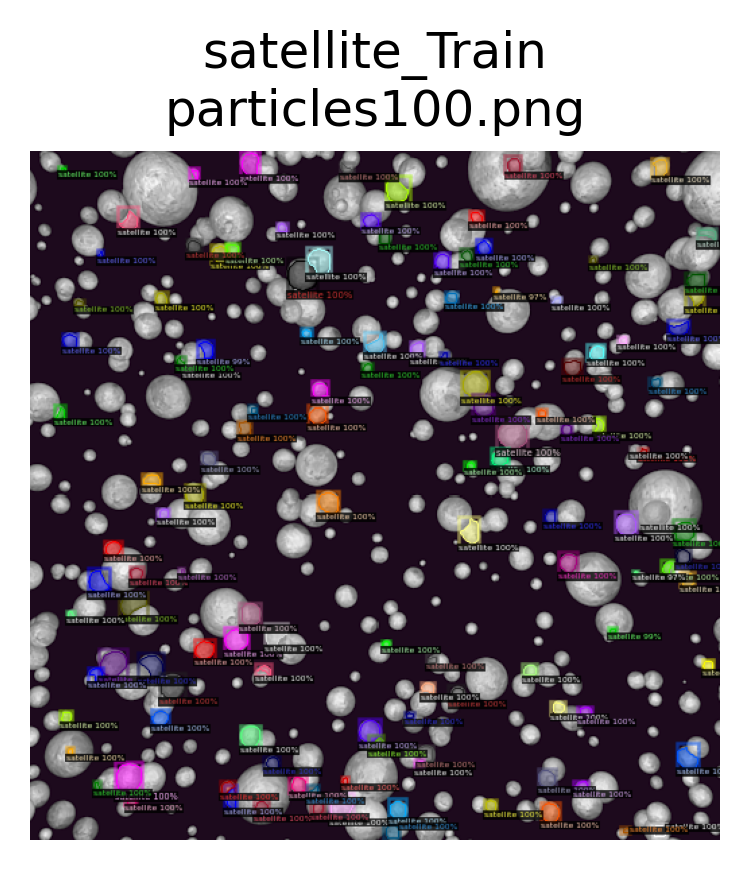

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png
	num_instances: 128
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles101.png


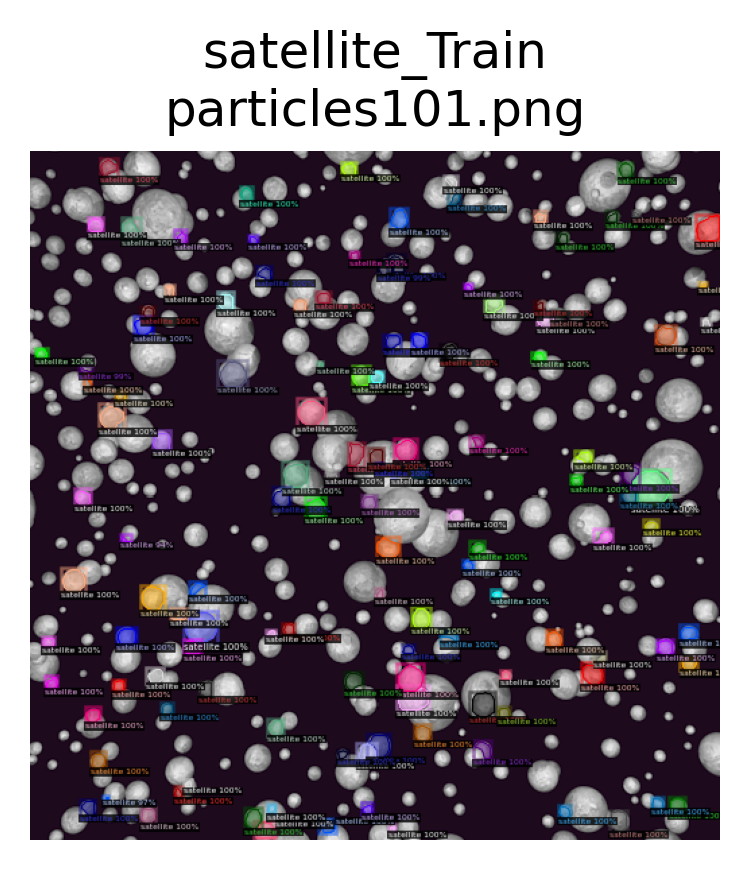

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles101.png
	num_instances: 129
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles102.png


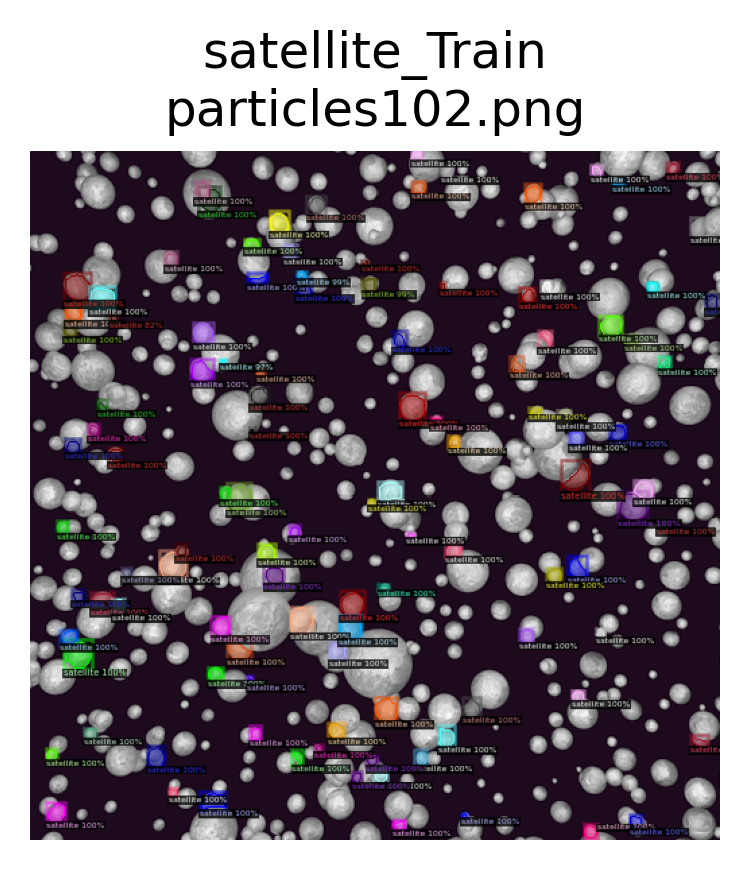

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles102.png
	num_instances: 111
Dataset: satellite_Val
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png


ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png
	num_instances: 100
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png


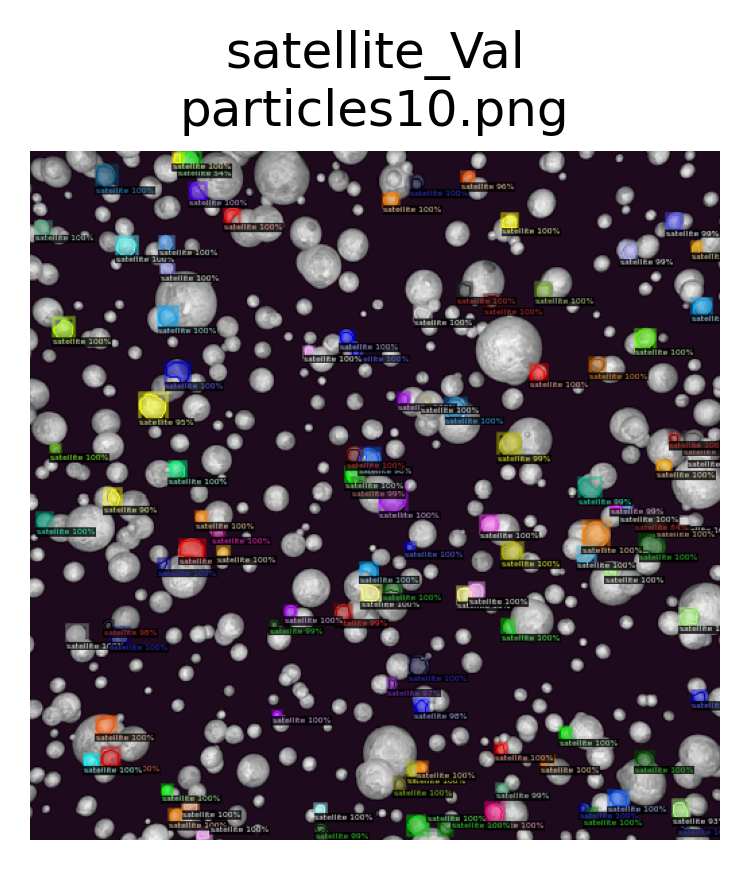

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png
	num_instances: 109
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png


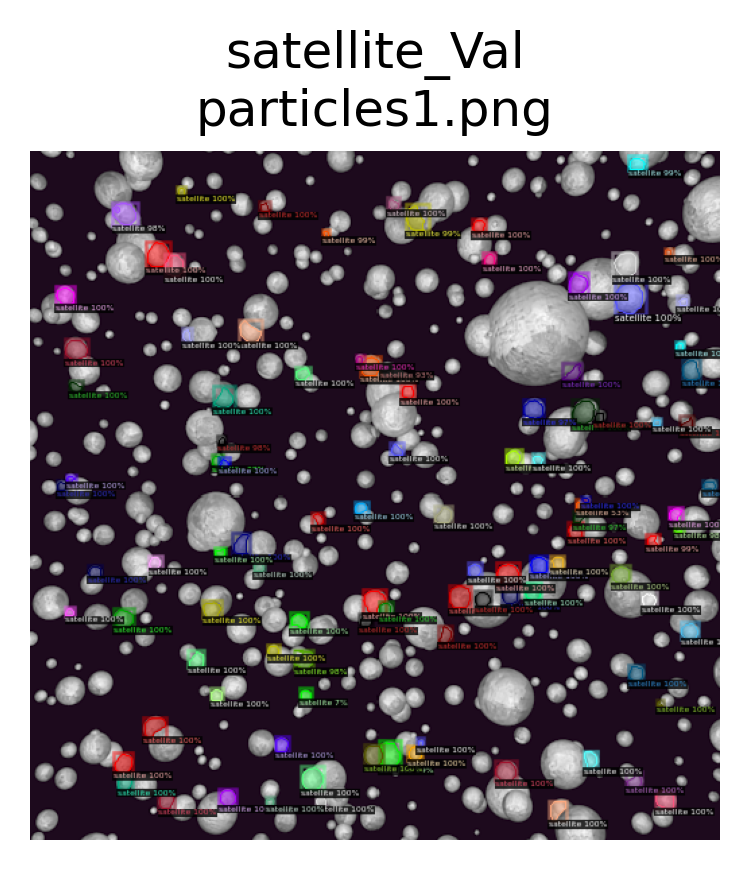

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png
	num_instances: 103


In [10]:
results = []
for ds in cfg.DATASETS.TEST:
    print(f'Dataset: {ds}')
    for dd in DatasetCatalog.get(ds):
        print(f'\tFile: {dd["file_name"]}')
        img = cv2.imread(dd['file_name'])  # load image
        outs = predictor(img)  # run inference on image
        
        # format results for visualization and store for later
        results.append(data_utils.format_outputs(dd['file_name'], ds, outs))

        # visualize results
        visualize.display_ddicts(outs, None, ds, gt=False, img_path=dd['file_name'])

# save to disk
#with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
#    pickle.dump(results, f)

## Generating predictions on new images is simple.
We will load a new image (not included in either dataset) and generate predictions.
Note that we do not have labels for this image and do not need to register it to a dataset.

In [9]:
img_path = Path('..', 'Auto_annotate_images','S01_02_SE1_300X06.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


AttributeError: 'NoneType' object has no attribute 'shape'

In [13]:
path = ocean_syn + 'images/a-lognormal-loc0.1-shape0.5/renders'
files = os.listdir(path)
img_names = []
for f in files:
    if f.split('.')[0] != 'particles103' and f.split('.')[0] != 'particles129' and f.split('.')[0] != 'particles159' and f.split('.')[0] != 'particles180':
        img_names.append(f.split('.')[0])
'''for f in img_names:
    print("Annotating: " + f)
    img_path = Path('..', 'data','images_png', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    export1 = export_anno.make_VIA_file(f +'.png', img_path, outs)
    export_anno.save_to_json(str(ampis_root) + f'/pred_annos/{EXPERIMENT_NAME}/' + f +'_anno.json', export1)
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                summary=False)  #hides the end print statement'''    
img_names.sort()
print(img_names)
for f in img_names:
    if len(f) > 9:
        print("Annotating: " + f)
        img_path = Path(path, f +'.png')
        img = cv2.imread(str(img_path))
        outs = predictor(img)
        #export1 = export_anno.make_VIA_file(f +'.png', img_path, outs)
        #export_anno.save_to_json(ocean_syn + 'pred_annos/a-lognormal-loc0.1-shape0.5/stage1.2/' + f +'_anno.json', export1)
        outs = predictor(img)
        data_utils.format_outputs(img_path, dataset='test', pred=outs)
        '''visualize.display_ddicts(ddict=outs,  # predictions to display
                                     outpath=None, dataset='Test',  # don't save fi$
                                     gt=False,  # specifies format as model predict$
                                     img_path=img_path, # path to image
                                     suppress_labels=True, #hides class images
                                     summary=True)  #hides the end print statement'''

['particles1', 'particles10', 'particles100', 'particles101', 'particles102', 'particles104', 'particles105', 'particles106', 'particles107', 'particles108', 'particles109', 'particles11', 'particles110', 'particles111', 'particles112', 'particles113', 'particles114', 'particles115', 'particles116', 'particles117', 'particles118', 'particles119', 'particles12', 'particles120', 'particles121', 'particles122', 'particles123', 'particles124', 'particles125', 'particles126', 'particles127', 'particles128', 'particles13', 'particles130', 'particles131', 'particles132', 'particles133', 'particles134', 'particles135', 'particles136', 'particles137', 'particles138', 'particles139', 'particles14', 'particles140', 'particles141', 'particles142', 'particles143', 'particles144', 'particles145', 'particles146', 'particles147', 'particles148', 'particles149', 'particles15', 'particles150', 'particles151', 'particles152', 'particles153', 'particles154', 'particles155', 'particles156', 'particles157',

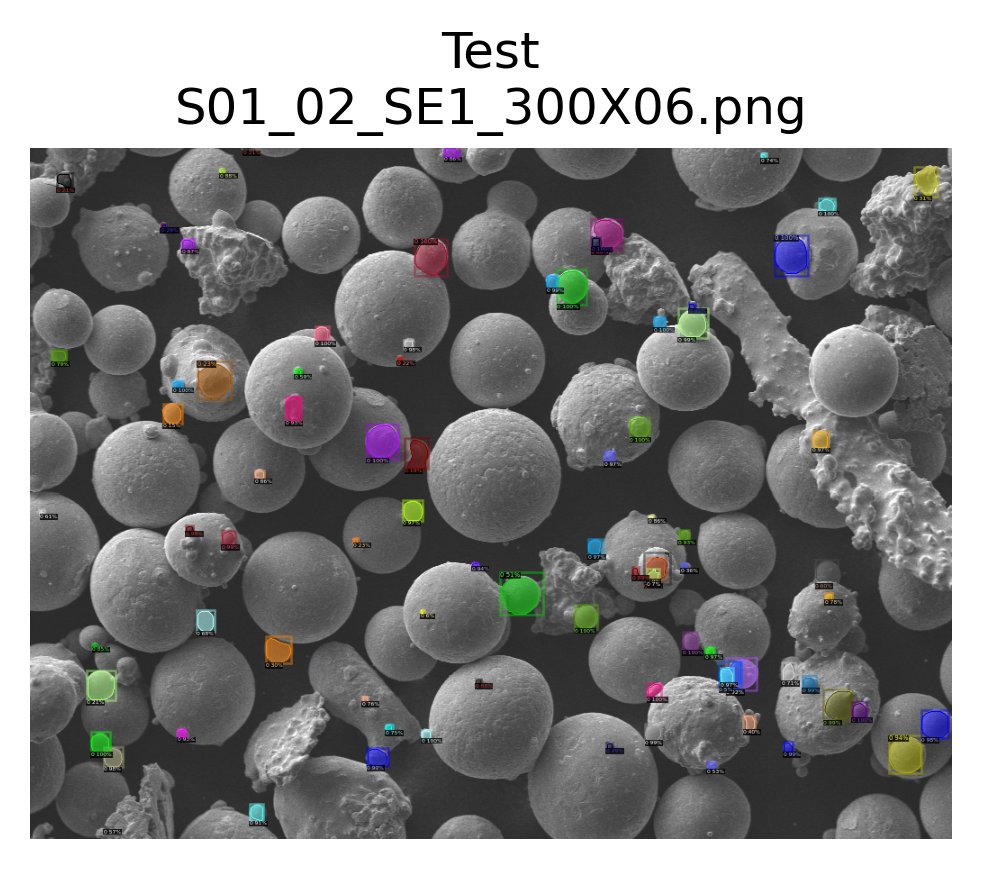

ddict info:
	path: ../Auto_annotate_images/S01_02_SE1_300X06.png
	num_instances: 84


In [11]:
img_path = Path('..', 'Auto_annotate_images','S01_02_SE1_300X06.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


We will now generate predictions on all of the images in the training and validation sets, and save the results for later.

In [8]:
files = os.listdir('Auto_annotate_images')
img_names = []
for f in files:
    if f.split('.')[0] != '250x' and f.split('.')[0] != '500x':
        img_names.append(f.split('.')[0])
        
results = []
for f in img_names:
    print("Annotating: " + f)
    img_path = Path('Auto_annotate_images', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement

# save to disk
with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
    pickle.dump(results, f)

FileNotFoundError: [Errno 2] No such file or directory: 'Auto_annotate_images'